# Flu Prediction Using Weather and Time Data

### Project Objective

This project aims to predict the weekly influenza rate in California, using environmental and time-based features. We use a machine learning approach to model flu activity trends with the goal of enhancing public health preparedness and anticipating outbreaks.

### Context

Influenza remains a significant public health issue, with seasonal patterns that can be influenced by both environmental conditions (e.g., temperature, humidity) and temporal dynamics (e.g., time of year, seasonality). 

We focus on:
- **Environmental factors**: to explore whether weather variables alone can predict flu trends
- **Temporal patterns**: to assess whether adding time-derived features (lags, seasonality) improves performance

### Methodology

We structure the project in the following steps:

1. **Data Preprocessing**: Cleaning and merging flu surveillance data with weather records
2. **Exploratory Data Analysis (EDA)**: Understanding flu patterns and potential correlations
3. **Feature Engineering**: Creating lag features and seasonality indicators
4. **Predictive Modeling**:
    - First, we train a model on the **overall population**
    - Then, we build models specific to **age categories** and **virus types**
5. **Evaluation and Visualization**: Comparing predicted vs actual flu rates for each model

### Goals

- Identify the predictive power of weather data
- Compare performance with and without temporal features
- Understand flu patterns across age groups and virus types

### Data Sources

We work with two primary datasets:

1. **Influenza Surveillance Data**: Contains weekly flu activity in US, including rates across age categories and virus types. In our case, we filtered it on California.
2. **Climate Data (gridMET)**: Provides weekly meteorological data such as temperature, humidity, wind speed, and precipitation.

# Step 1: Data Loading, Preparation & Cleaning

We start by preparing the influenza and weather datasets to ensure alignment on a weekly temporal basis.

- The flu dataset (`df_flu`) includes weekly influenza-like illness (ILI) rates by age group and virus type. 
- The weather dataset (`df_weather`) contains daily meteorological variables, which we aggregate to a weekly level by aligning all dates to Mondays.

### Key Steps:
- Convert flu dates using `YEAR` and `WEEK` into a proper datetime format.
- Align weather `time` values to the beginning of the week (Monday).
- Perform a **left join** on the `date` column to merge flu and weather data.
- Keep only relevant columns in the flu dataset (`AGE CATEGORY`, `VIRUS TYPE CATEGORY`, `date`, and `WEEKLY RATE`).
- Drop all rows with missing values in the weather data **but keep rows with missing `WEEKLY RATE`** (our target), as we may want to impute or discard them later.

This ensures that our dataset is consistent, aligned temporally, and free of rows with missing predictors.

### Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np

# Load flu and weather datasets
df_flu = pd.read_csv("../data/california.csv", sep=",")
df_weather = pd.read_csv("../data/california gridmet.csv")

### Data Cleaning

In [2]:
# Drop unnecessary columns from df_flu
df_flu = df_flu.drop(columns=["YEAR", "CUMULATIVE RATE"])
# Rename columns for clarity
df_flu = df_flu.rename(columns={"YEAR.1": "YEAR"})

df_flu.head()

# Check and convert date formats if needed
df_flu["date"] = pd.to_datetime(df_flu["YEAR"].astype(str) + "-W" + df_flu["WEEK"].astype(str) + "-1", format="%Y-W%W-%w")
df_weather["time"] = pd.to_datetime(df_weather["time"], errors='coerce')  # Convert 'time' to datetime
df_weather["date"] = df_weather["time"] + pd.offsets.Week(weekday=0)  # Align to Monday

# Filter df_flu to keep only 'Overall' values for Race and Sex categories
df_flu = df_flu[(df_flu["RACE CATEGORY"] == "Overall") & (df_flu["SEX CATEGORY"] == "Overall")]

# Filter df_flu on relevant columns only
df_flu = df_flu[["AGE CATEGORY", "VIRUS TYPE CATEGORY", "date", "WEEKLY RATE"]]

# Merge flu and weather data on date
df_merged = pd.merge(df_flu, df_weather, on="date", how="left")

# Drop missing values
df_merged = df_merged.dropna().reset_index(drop=True)

# Display preview
df_merged.head()

,AGE CATEGORY,VIRUS TYPE CATEGORY,date,WEEKLY RATE,time,air_temperature,burning_index_g,dead_fuel_moisture_1000hr,dead_fuel_moisture_100hr,mean_vapor_pressure_deficit,potential_evapotranspiration,precipitation_amount,relative_humidity,specific_humidity,surface_downwelling_shortwave_flux_in_air,wind_from_direction,wind_speed
0,Overall,Influenza A,2017-01-02,4.1,2017-01-01,269.556,9.551213,25.256285,20.628801,0.223459,0.765277,1.198322,52.234997,0.003712,104.11324,234.65141,3.699632
1,Overall,Overall,2017-01-02,4.3,2017-01-01,269.556,9.551213,25.256285,20.628801,0.223459,0.765277,1.198322,52.234997,0.003712,104.11324,234.65141,3.699632
2,Overall,Influenza B,2017-01-02,0.2,2017-01-01,269.556,9.551213,25.256285,20.628801,0.223459,0.765277,1.198322,52.234997,0.003712,104.11324,234.65141,3.699632
3,Overall,Overall,2017-01-02,12.0,2017-01-01,269.556,9.551213,25.256285,20.628801,0.223459,0.765277,1.198322,52.234997,0.003712,104.11324,234.65141,3.699632
4,Overall,Influenza B,2017-01-02,0.1,2017-01-01,269.556,9.551213,25.256285,20.628801,0.223459,0.765277,1.198322,52.234997,0.003712,104.11324,234.65141,3.699632


# Step 2: Feature Engineering

To enhance model performance, we engineer several new features based on temporal and weather information. These include:

1. **Temporal Features**: Add time-based variables to help capture seasonality and flu season patterns.
2. **Lag Features**: Create lagged versions of key predictors to capture delayed effects (e.g., temperature from 1–3 weeks ago).
3. **Rolling Averages**: Smooth out noise in weather data by computing moving averages over recent weeks.

These additions aim to enhance our model’s predictive power by capturing:
- seasonal flu dynamics,
- temporal autocorrelation,
- delayed weather effects on flu incidence.

This step is crucial to enrich the dataset and give our model access to temporal dynamics without explicitly encoding future information (avoiding data leakage).

In [3]:
# === Temporal Features ===
df_merged['weekofyear'] = df_merged['date'].dt.isocalendar().week.astype(int)
df_merged['month'] = df_merged['date'].dt.month

# Binary flag for flu season (October to April)
df_merged['is_flu_season'] = df_merged['month'].isin([10, 11, 12, 1, 2, 3, 4]).astype(int)

# === Lag Features ===
# Sort chronologically before creating lags
df_merged = df_merged.sort_values("date")

# Define lags and variables to lag
lags = [1, 2, 3]
lag_features = [
    'WEEKLY RATE',
    'air_temperature',
    'precipitation_amount',
    'specific_humidity',
    'wind_speed'
]

# Create lagged features
for feature in lag_features:
    for lag in lags:
        lag_col = f"{feature.lower().replace(' ', '_')}_lag{lag}"
        df_merged[lag_col] = df_merged[feature].shift(lag)

# === Rolling Means ===
rolling_windows = [2, 3, 4]  # Weekly rolling windows

for feature in ['air_temperature', 'precipitation_amount', 'specific_humidity']:
    for window in rolling_windows:
        roll_col = f"{feature.lower().replace(' ', '_')}_roll{window}"
        df_merged[roll_col] = df_merged[feature].shift(1).rolling(window=window).mean()
        
# === Cyclic encoding ===
import numpy as np
df_merged["week_sin"] = np.sin(2 * np.pi * df_merged["weekofyear"] / 52)
df_merged["week_cos"] = np.cos(2 * np.pi * df_merged["weekofyear"] / 52)

# === Temp vs monthly average ===
monthly_avg_temp = df_merged.groupby("month")["air_temperature"].transform("mean")
df_merged["temp_anomaly"] = df_merged["air_temperature"] - monthly_avg_temp

# Drop rows with NaNs introduced by lags/rolling windows
df_merged = df_merged.dropna().reset_index(drop=True)

# Preview
df_merged.head()

,AGE CATEGORY,VIRUS TYPE CATEGORY,date,WEEKLY RATE,time,air_temperature,burning_index_g,dead_fuel_moisture_1000hr,dead_fuel_moisture_100hr,mean_vapor_pressure_deficit,...,air_temperature_roll4,precipitation_amount_roll2,precipitation_amount_roll3,precipitation_amount_roll4,specific_humidity_roll2,specific_humidity_roll3,specific_humidity_roll4,week_sin,week_cos,temp_anomaly
0,30-39 yr,Overall,2017-01-02,1.9,2017-01-01,269.556,9.551213,25.256285,20.628801,0.223459,...,269.556,1.198322,1.198322,1.198322,0.003712,0.003712,0.003712,0.120537,0.992709,-7.335762
1,>= 18,Overall,2017-01-02,14.7,2017-01-01,269.556,9.551213,25.256285,20.628801,0.223459,...,269.556,1.198322,1.198322,1.198322,0.003712,0.003712,0.003712,0.120537,0.992709,-7.335762
2,>= 18,Overall,2017-01-02,5.3,2017-01-01,269.556,9.551213,25.256285,20.628801,0.223459,...,269.556,1.198322,1.198322,1.198322,0.003712,0.003712,0.003712,0.120537,0.992709,-7.335762
3,>= 65 yr,Overall,2017-01-02,63.0,2017-01-01,269.556,9.551213,25.256285,20.628801,0.223459,...,269.556,1.198322,1.198322,1.198322,0.003712,0.003712,0.003712,0.120537,0.992709,-7.335762
4,>= 65 yr,Overall,2017-01-02,21.6,2017-01-01,269.556,9.551213,25.256285,20.628801,0.223459,...,269.556,1.198322,1.198322,1.198322,0.003712,0.003712,0.003712,0.120537,0.992709,-7.335762


In [4]:
# === Time Lag Features for Model 1.2 ===

# Ensure data is sorted before creating lag features
df_enhanced= df_merged.sort_values("date").copy()

# Create lag and rolling features for each AGE & VIRUS group (avoid leakage)
group_cols = ["AGE CATEGORY", "VIRUS TYPE CATEGORY"]

# Apply shift and rolling within each group
df_enhanced["weekly_rate_lag1"] = df_enhanced.groupby(group_cols)["WEEKLY RATE"].shift(1)
df_enhanced["weekly_rate_lag2"] = df_enhanced.groupby(group_cols)["WEEKLY RATE"].shift(2)
df_enhanced["weekly_rate_lag3"] = df_enhanced.groupby(group_cols)["WEEKLY RATE"].shift(3)

df_enhanced["weekly_rate_ma3"] = df_enhanced.groupby(group_cols)["WEEKLY RATE"].transform(lambda x: x.rolling(3).mean())
df_enhanced["weekly_rate_ma5"] = df_enhanced.groupby(group_cols)["WEEKLY RATE"].transform(lambda x: x.rolling(5).mean())

# Preview
df_enhanced.head()


,AGE CATEGORY,VIRUS TYPE CATEGORY,date,WEEKLY RATE,time,air_temperature,burning_index_g,dead_fuel_moisture_1000hr,dead_fuel_moisture_100hr,mean_vapor_pressure_deficit,...,precipitation_amount_roll3,precipitation_amount_roll4,specific_humidity_roll2,specific_humidity_roll3,specific_humidity_roll4,week_sin,week_cos,temp_anomaly,weekly_rate_ma3,weekly_rate_ma5
0,30-39 yr,Overall,2017-01-02,1.9,2017-01-01,269.556,9.551213,25.256285,20.628801,0.223459,...,1.198322,1.198322,0.003712,0.003712,0.003712,0.120537,0.992709,-7.335762,NaN,NaN
21,>= 75,Overall,2017-01-02,115.4,2017-01-01,269.556,9.551213,25.256285,20.628801,0.223459,...,1.198322,1.198322,0.003712,0.003712,0.003712,0.120537,0.992709,-7.335762,NaN,NaN
22,>= 75,Overall,2017-01-02,39.0,2017-01-01,269.556,9.551213,25.256285,20.628801,0.223459,...,1.198322,1.198322,0.003712,0.003712,0.003712,0.120537,0.992709,-7.335762,NaN,NaN
23,1-4 yr,Overall,2017-01-02,1.9,2017-01-01,269.556,9.551213,25.256285,20.628801,0.223459,...,1.198322,1.198322,0.003712,0.003712,0.003712,0.120537,0.992709,-7.335762,NaN,NaN
24,5-17 yr,Overall,2017-01-02,0.3,2017-01-01,269.556,9.551213,25.256285,20.628801,0.223459,...,1.198322,1.198322,0.003712,0.003712,0.003712,0.120537,0.992709,-7.335762,NaN,NaN


# Step 4: Prediction Models

## Model 1: Global Flu Rate Prediction (AGE CATEGORY == 'Overall' & VIRUS TYPE CATEGORY == 'Overall')

We aim to forecast weekly flu rates at the global level by focusing on entries where AGE CATEGORY == 'Overall' and VIRUS TYPE CATEGORY == 'Overall'.
This helps us build a baseline model before diving into subgroup-specific predictions (e.g., per age group or virus type).

To understand how predictive power evolves with feature engineering, we build two models:
- Model 1.1 uses only weather-related variables (temperature, humidity, wind, etc.).
- Model 1.2 incorporates time-lagged flu rates and rolling averages, capturing recent epidemic trends and temporal dynamics.

This structure allows us to assess how much temporal information improves flu rate forecasting.

### Model 1.1: prediction using weather-only features

In [5]:
# Data Preparation for Modeling
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === 1. Filter ===
df_model = df_merged[
    (df_merged["AGE CATEGORY"] == "Overall") &
    (df_merged["VIRUS TYPE CATEGORY"] == "Overall") &
    (df_merged["is_flu_season"] == 1)
].copy().dropna().sort_values("date").reset_index(drop=True)

# === 2. Define target and features ===
df_model["target_log"] = np.log1p(df_model["WEEKLY RATE"])

exclude = [
    "date", "time", "WEEKLY RATE", "YEAR", "WEEK", 
    "month", "weekofyear",  # we keep week_sin/cos instead
    "AGE CATEGORY", "VIRUS TYPE CATEGORY", "target_log"
]

X = df_model.drop(columns=exclude, errors="ignore")
X = X.select_dtypes(include=["number"])
y_log = df_model["target_log"]

# === 3. Temporal split ===
split_idx = int(len(df_model) * 0.7)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y_log.iloc[:split_idx]
y_test = y_log.iloc[split_idx:]

# === 4. Train Random Forest ===
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# === 5. Predict & invert log
y_pred_log = rf.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_true = np.expm1(y_test)

# === 6. Evaluation
rmse = np.sqrt(mean_squared_error(y_test_true, y_pred))
r2 = r2_score(y_test_true, y_pred)

print("Random Forest with log-transformed target")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")

Random Forest with log-transformed target
RMSE: 1.08
R²:   0.659


#### Plot Actual vs Predicted

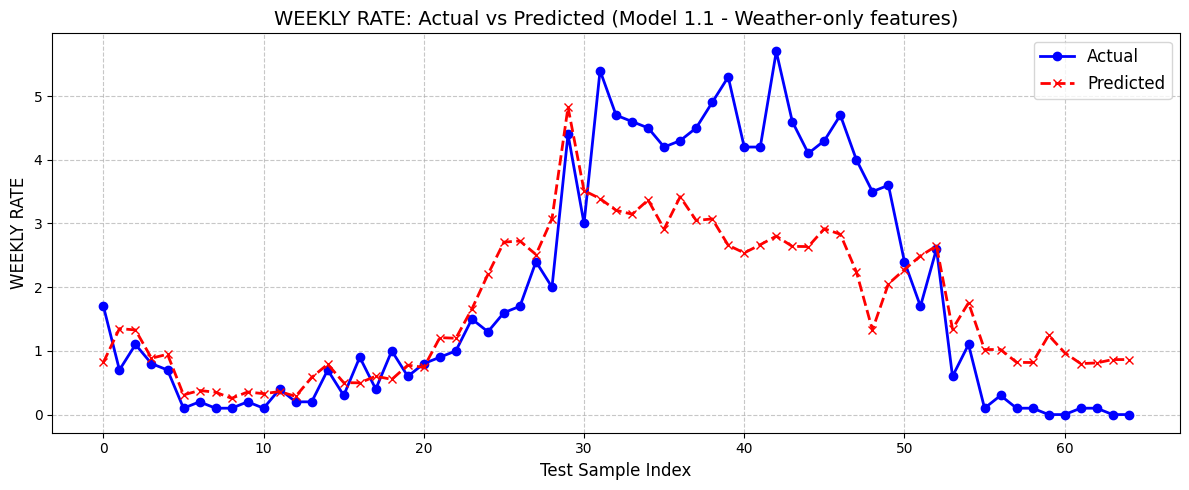

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot actual values
plt.plot(y_test_true.values, label="Actual", marker='o', color='blue', linewidth=2)

# Plot predicted values
plt.plot(y_pred, label="Predicted", marker='x', linestyle='--', color='red', linewidth=2)

# Labels and title
plt.title("WEEKLY RATE: Actual vs Predicted (Model 1.1 - Weather-only features)", fontsize=14)
plt.xlabel("Test Sample Index", fontsize=12)
plt.ylabel("WEEKLY RATE", fontsize=12)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#### Top 15 Feature Importances

<Axes: title={'center': 'Top 15 Feature Importances'}>

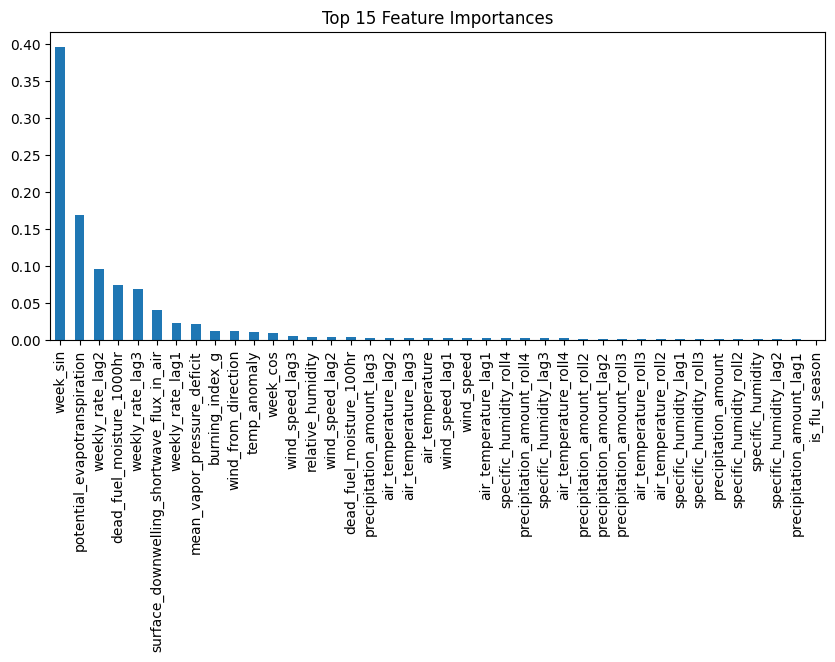

In [7]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(50).plot(kind='bar', figsize=(10, 4), title="Top 15 Feature Importances")

#### K-Fold Cross-Validation (Time Series Split)

In [8]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
r2_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y_log.iloc[train_idx], y_log.iloc[test_idx]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_tr, y_tr)

    y_pred_log = model.predict(X_te)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_te)

    r2 = r2_score(y_true, y_pred)
    r2_scores.append(r2)
    print(f"Fold {fold+1} — R²: {r2:.3f}")

print(f"\nAverage R²: {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")

Fold 1 — R²: 0.068
Fold 2 — R²: 0.722
Fold 3 — R²: -1.897
Fold 4 — R²: 0.714
Fold 5 — R²: 0.538

Average R²: 0.029 ± 0.992


#### Model Comparison with Time Series Cross-Validation

We evaluate four different regression models on the time series data using 5-fold `TimeSeriesSplit`.  
Each model is trained on log-transformed targets and evaluated using the R² score on the inverse-transformed predictions (`np.expm1`).

This approach helps assess each model’s ability to generalize across temporal splits — a more realistic setup for forecasting tasks.

**Models compared:**
- Random Forest Regressor
- Ridge Regression
- Gradient Boosting Regressor
- XGBoost Regressor
- Support Vector Regressor (RBF)

The models are evaluated using three metrics on the original scale:
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- R² score

The best-performing model is selected based on the lowest RMSE.

In [9]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Remove datetime columns if any
X_train_clean = X_train.drop(columns=["date"], errors="ignore")
X_test_clean = X_test.drop(columns=["date"], errors="ignore")

# Dictionary of models to test
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "Ridge Regression": Ridge(alpha=1.0),
    "SVR (RBF)": SVR(kernel='rbf', C=1.0, epsilon=0.2)
}

results = []

for name, model in models.items():
    model.fit(X_train_clean, y_train)  # y_train is log-transformed
    y_pred_log = model.predict(X_test_clean)
    y_pred = np.expm1(y_pred_log)     # inverse transform
    y_true = np.expm1(y_test)         # inverse transform

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

# Display results
results_df = pd.DataFrame(results).sort_values(by="RMSE")
best_model_name = results_df.iloc[0]["Model"]

print("### Model Comparison Results:")
display(results_df.round(3))
print(f"\n Best Model (lowest RMSE): **{best_model_name}**")

### Model Comparison Results:


,Model,MAE,RMSE,R²
3,Ridge Regression,0.806,1.075,0.661
0,Random Forest,0.857,1.109,0.640
2,XGBoost,0.819,1.117,0.635
1,Gradient Boosting,0.912,1.174,0.597
4,SVR (RBF),1.377,1.641,0.212



 Best Model (lowest RMSE): **Ridge Regression**


### Model 1.2: prediction using weather and time-lag features

In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Filter only 'Overall' and flu season
df_model2 = df_enhanced[
    (df_enhanced["AGE CATEGORY"] == "Overall") &
    (df_enhanced["VIRUS TYPE CATEGORY"] == "Overall") &
    (df_enhanced["is_flu_season"] == 1)
].copy().dropna().sort_values("date").reset_index(drop=True)

# 2. Define log target
df_model2["target_log"] = np.log1p(df_model2["WEEKLY RATE"])

# 3. Define features (keep lag & roll features)
exclude = [
    "date", "time", "WEEKLY RATE", "YEAR", "WEEK",
    "month", "weekofyear",  # keep week_sin/cos instead
    "AGE CATEGORY", "VIRUS TYPE CATEGORY", "target_log"
]

X = df_model2.drop(columns=exclude, errors="ignore")
X = X.select_dtypes(include=["number"])  # Keep only numerical features
y_log = df_model2["target_log"]

# 4. Temporal split (70/30)
split_idx = int(len(df_model2) * 0.7)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y_log.iloc[:split_idx]
y_test = y_log.iloc[split_idx:]

# 5. Train model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred_log = rf.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_test_true, y_pred))
r2 = r2_score(y_test_true, y_pred)

print("Random Forest with log-transformed target and time-lag features")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")

Random Forest with log-transformed target and time-lag features
RMSE: 0.43
R²:   0.946


#### Plot Actual VS Predicted

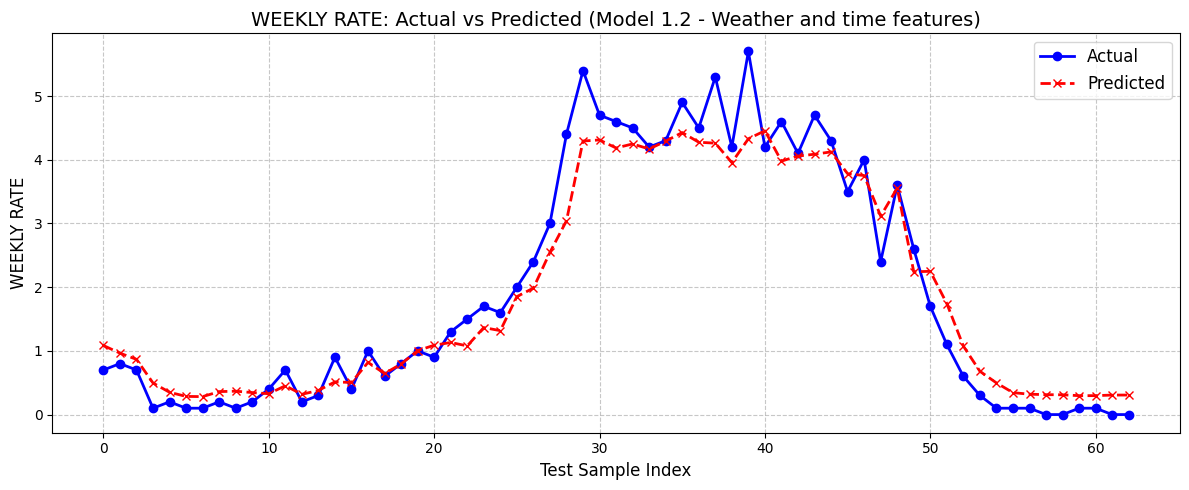

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot actual values
plt.plot(y_test_true.values, label="Actual", marker='o', color='blue', linewidth=2)

# Plot predicted values
plt.plot(y_pred, label="Predicted", marker='x', linestyle='--', color='red', linewidth=2)

# Labels and title
plt.title("WEEKLY RATE: Actual vs Predicted (Model 1.2 - Weather and time features)", fontsize=14)
plt.xlabel("Test Sample Index", fontsize=12)
plt.ylabel("WEEKLY RATE", fontsize=12)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#### Top 15 Feature Importances (Model 1.2 - Weather and time features)

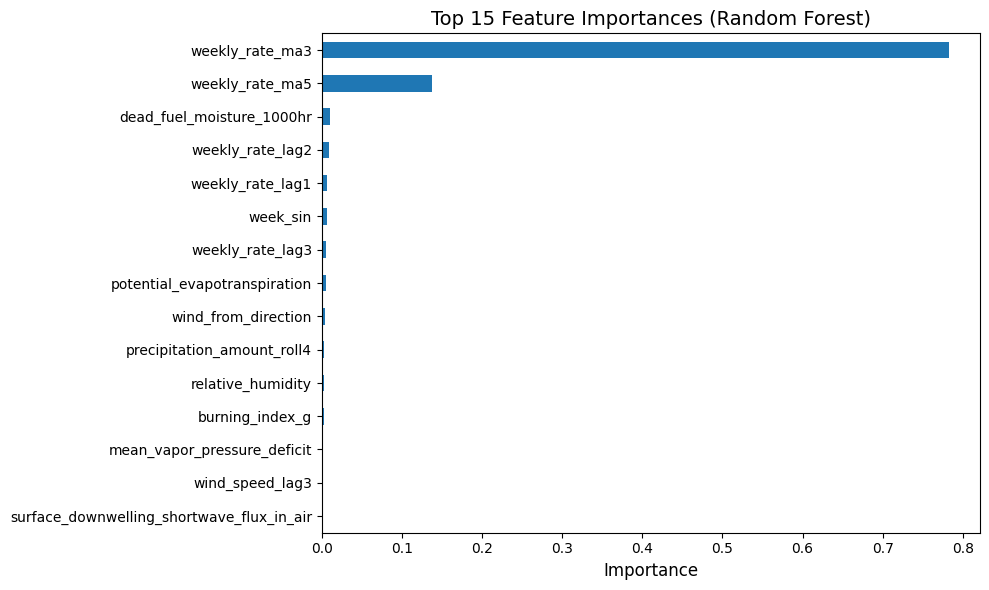

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the trained model
importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Sort and plot the top 15 features
top_n = 15
top_features = importances.sort_values(ascending=True).tail(top_n)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.title("Top 15 Feature Importances (Random Forest)", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.tight_layout()
plt.show()

#### K-Fold Cross-Validation (Time Series Split)

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

# 1. Filter only 'Overall' and flu season
df_model2 = df_enhanced[
    (df_enhanced["AGE CATEGORY"] == "Overall") &
    (df_enhanced["VIRUS TYPE CATEGORY"] == "Overall") &
    (df_enhanced["is_flu_season"] == 1)
].copy().dropna().sort_values("date").reset_index(drop=True)

# 2. Define log-transformed target
df_model2["target_log"] = np.log1p(df_model2["WEEKLY RATE"])

# 3. Select features
exclude = [
    "date", "time", "WEEKLY RATE", "YEAR", "WEEK",
    "month", "weekofyear",
    "AGE CATEGORY", "VIRUS TYPE CATEGORY", "target_log"
]

X = df_model2.drop(columns=exclude, errors="ignore")
X = X.select_dtypes(include=["number"])
y_log = df_model2["target_log"]

# 4. TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)
r2_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y_log.iloc[train_idx], y_log.iloc[test_idx]

    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_tr, y_tr)

    y_pred_log = model.predict(X_te)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_te)

    r2 = r2_score(y_true, y_pred)
    r2_scores.append(r2)

    print(f"Fold {fold+1} — R²: {r2:.3f}")

print(f"\nAverage R²: {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")

Fold 1 — R²: 0.255
Fold 2 — R²: 0.824
Fold 3 — R²: 0.693
Fold 4 — R²: 0.825
Fold 5 — R²: 0.939

Average R²: 0.707 ± 0.239


#### Model Comparison with Time Series Cross-Validation

We evaluate four different regression models on the time series data using 5-fold `TimeSeriesSplit`.  
Each model is trained on log-transformed targets and evaluated using the R² score on the inverse-transformed predictions (`np.expm1`).

This approach helps assess each model’s ability to generalize across temporal splits — a more realistic setup for forecasting tasks.

**Models compared:**
- Random Forest Regressor
- Ridge Regression
- Gradient Boosting Regressor
- XGBoost Regressor
- Support Vector Regressor (RBF)

The models are evaluated using three metrics on the original scale:
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- R² score

The best-performing model is selected based on the lowest RMSE.

In [14]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Remove datetime columns if any
X_train_clean = X_train.drop(columns=["date"], errors="ignore")
X_test_clean = X_test.drop(columns=["date"], errors="ignore")

# Dictionary of models to test
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "Ridge Regression": Ridge(alpha=1.0),
    "SVR (RBF)": SVR(kernel='rbf', C=1.0, epsilon=0.2)
}

results = []

for name, model in models.items():
    model.fit(X_train_clean, y_train)  # y_train is log-transformed
    y_pred_log = model.predict(X_test_clean)
    y_pred = np.expm1(y_pred_log)     # inverse transform
    y_true = np.expm1(y_test)         # inverse transform

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

# Display results
results_df = pd.DataFrame(results).sort_values(by="RMSE")
best_model_name = results_df.iloc[0]["Model"]

print("Model Comparison Results:")
display(results_df.round(3))
print(f"\n Best Model (lowest RMSE): {best_model_name}")

Model Comparison Results:


,Model,MAE,RMSE,R²
0,Random Forest,0.324,0.427,0.948
1,Gradient Boosting,0.315,0.433,0.947
2,XGBoost,0.404,0.482,0.934
3,Ridge Regression,0.609,0.841,0.799
4,SVR (RBF),1.430,1.694,0.183



 Best Model (lowest RMSE): Random Forest


### Conclusion: Model 1.1 vs 1.2

By adding time-lagged features in Model 1.2, we significantly improved prediction performance:
- The R² increased from ~0.64 to ~0.94 (Random Forest)
- The RMSE was reduced by ~60%, indicating much closer predictions to reality

This improvement is expected because flu rates are autocorrelated over time, a high rate this week is likely to be followed by another high rate next week.
Even though weather affects flu indirectly (via transmission conditions), it cannot fully explain short-term epidemic spikes (e.g., during a pandemic).

Time-lag features provide crucial epidemiological memory, making the model much more reliable in real-world scenarios where the disease propagates gradually over time.

## Model 2: Flu Rate Prediction by Age and Virus Type

In this section, we evaluate whether splitting the dataset by **AGE CATEGORY** or **VIRUS TYPE CATEGORY** improves prediction performance.

Unlike Model 1 (which used aggregated data with `AGE CATEGORY == 'Overall'` and `VIRUS TYPE CATEGORY == 'Overall'`), here we train separate models per subgroup.

### Objective:
- Assess whether age or virus-specific dynamics can be better captured using independent models.
- We retain the **same modeling strategy as Model 1.2**, including:
  - log-transformed target (`log1p`)
  - weather and time-lag features
  - Random Forest Regressor
  - 70/30 temporal split

We only keep the best-performing configuration (with time-lag features), based on prior results.

### Training a RF model per age group

#### Age group = Seniors (65+)

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# === 1. Select subset ===
age_group = ">= 65 yr"  #change to test other groups
df_age = df_enhanced[
    (df_enhanced["AGE CATEGORY"] == age_group) &
    (df_enhanced["VIRUS TYPE CATEGORY"] == "Overall") &
    (df_enhanced["is_flu_season"] == 1)
].copy().dropna().sort_values("date").reset_index(drop=True)

# === 2. Log transform target ===
df_age["target_log"] = np.log1p(df_age["WEEKLY RATE"])

# === 3. Define features ===
exclude = [
    "date", "time", "WEEKLY RATE", "YEAR", "WEEK",
    "month", "weekofyear", "AGE CATEGORY", "VIRUS TYPE CATEGORY", "target_log"
]
X = df_age.drop(columns=exclude, errors="ignore").select_dtypes(include="number")
y_log = df_age["target_log"]

# === 4. Temporal train/test split (70/30) ===
# Ensure there are enough rows for the split
if len(df_age) < 10:  # Minimum threshold for train/test split
    print(f"Not enough data points ({len(df_age)}) in the filtered dataset for train/test split.")
    print("Skipping training for AGE CATEGORY =", age_group)
else:
    # Proceed with train/test split and model training
    split_idx = max(1, int(len(df_age) * 0.7))  # Ensure at least one sample in training set
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_log.iloc[:split_idx], y_log.iloc[split_idx:]

    # Train model
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_log = rf.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"Random Forest for AGE CATEGORY = {age_group}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.3f}")

# Ensure there are enough rows for the split
if len(df_age) < 10:  # Minimum threshold for train/test split
    print(f"Not enough data points ({len(df_age)}) in the filtered dataset for train/test split.")
    print("Skipping training for AGE CATEGORY =", age_group)
else:
    # Proceed with train/test split and model training
    split_idx = max(1, int(len(df_age) * 0.7))  # Ensure at least one sample in training set
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_log.iloc[:split_idx], y_log.iloc[split_idx:]

    # Train model
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_log = rf.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"Random Forest for AGE CATEGORY = {age_group}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.3f}")

Random Forest for AGE CATEGORY = >= 65 yr
RMSE: 1.65
R²:   0.913
Random Forest for AGE CATEGORY = >= 65 yr
RMSE: 1.65
R²:   0.913


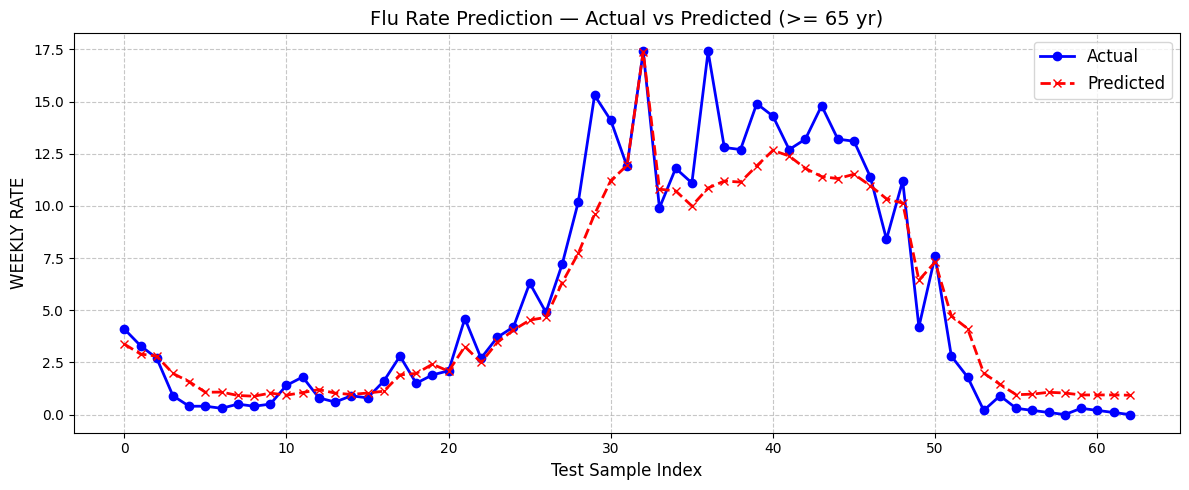

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot actual values
plt.plot(y_true.values, label="Actual", marker='o', color='blue', linewidth=2)

# Plot predicted values
plt.plot(y_pred, label="Predicted", marker='x', linestyle='--', color='red', linewidth=2)

# Title and axis labels
plt.title(f"Flu Rate Prediction — Actual vs Predicted ({age_group})", fontsize=14)
plt.xlabel("Test Sample Index", fontsize=12)
plt.ylabel("WEEKLY RATE", fontsize=12)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#### Age group = Toddlers (0-4 yr)

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# === 1. Select subset ===
age_group = "0-4 yr"  #change to test other groups
df_age = df_enhanced[
    (df_enhanced["AGE CATEGORY"] == age_group) &
    (df_enhanced["VIRUS TYPE CATEGORY"] == "Overall") &
    (df_enhanced["is_flu_season"] == 1)
].copy().dropna().sort_values("date").reset_index(drop=True)

# === 2. Log transform target ===
df_age["target_log"] = np.log1p(df_age["WEEKLY RATE"])

# === 3. Define features ===
exclude = [
    "date", "time", "WEEKLY RATE", "YEAR", "WEEK",
    "month", "weekofyear", "AGE CATEGORY", "VIRUS TYPE CATEGORY", "target_log"
]
X = df_age.drop(columns=exclude, errors="ignore").select_dtypes(include="number")
y_log = df_age["target_log"]

# === 4. Temporal train/test split (70/30) ===
# Ensure there are enough rows for the split
if len(df_age) < 10:  # Minimum threshold for train/test split
    print(f"Not enough data points ({len(df_age)}) in the filtered dataset for train/test split.")
    print("Skipping training for AGE CATEGORY =", age_group)
else:
    # Proceed with train/test split and model training
    split_idx = max(1, int(len(df_age) * 0.7))  # Ensure at least one sample in training set
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_log.iloc[:split_idx], y_log.iloc[split_idx:]

    # Train model
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_log = rf.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"Random Forest for AGE CATEGORY = {age_group}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.3f}")

# Ensure there are enough rows for the split
if len(df_age) < 10:  # Minimum threshold for train/test split
    print(f"Not enough data points ({len(df_age)}) in the filtered dataset for train/test split.")
    print("Skipping training for AGE CATEGORY =", age_group)
else:
    # Proceed with train/test split and model training
    split_idx = max(1, int(len(df_age) * 0.7))  # Ensure at least one sample in training set
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_log.iloc[:split_idx], y_log.iloc[split_idx:]

    # Train model
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_log = rf.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"Random Forest for AGE CATEGORY = {age_group}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.3f}")

Random Forest for AGE CATEGORY = 0-4 yr
RMSE: 1.22
R²:   0.768
Random Forest for AGE CATEGORY = 0-4 yr
RMSE: 1.22
R²:   0.768


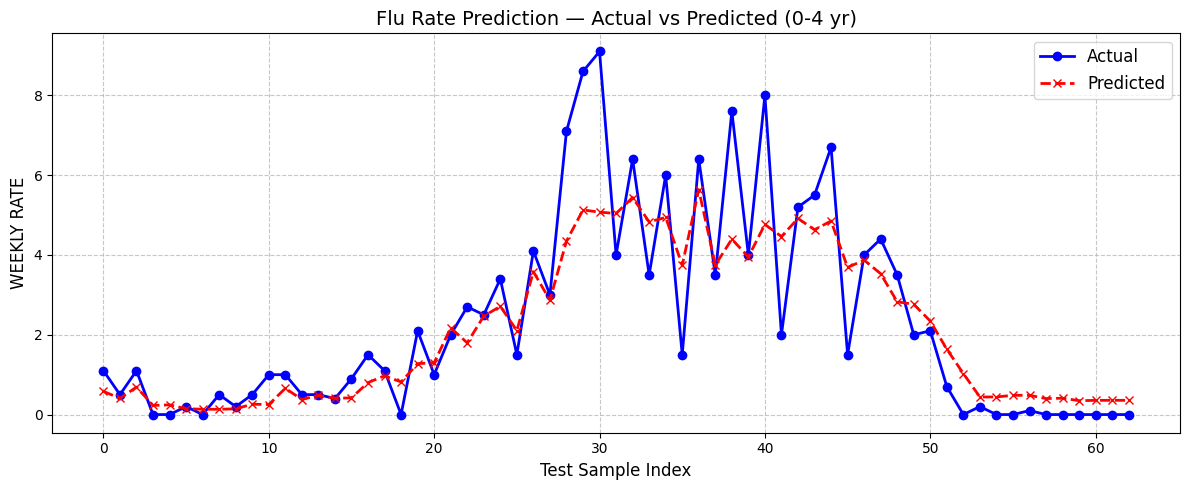

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot actual values
plt.plot(y_true.values, label="Actual", marker='o', color='blue', linewidth=2)

# Plot predicted values
plt.plot(y_pred, label="Predicted", marker='x', linestyle='--', color='red', linewidth=2)

# Title and axis labels
plt.title(f"Flu Rate Prediction — Actual vs Predicted ({age_group})", fontsize=14)
plt.xlabel("Test Sample Index", fontsize=12)
plt.ylabel("WEEKLY RATE", fontsize=12)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Training a RF model per Virus Type

#### Virus Type: Influenza A

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# === 1. Select subset ===
virus_group = "Influenza A"
df_virus = df_enhanced[
    (df_enhanced["AGE CATEGORY"] == "Overall") &
    (df_enhanced["VIRUS TYPE CATEGORY"] == virus_group) &
    (df_enhanced["is_flu_season"] == 1)
].copy().dropna().sort_values("date").reset_index(drop=True)

# === 2. Log transform target ===
df_virus["target_log"] = np.log1p(df_age["WEEKLY RATE"])

# === 3. Define features ===
exclude = [
    "date", "time", "WEEKLY RATE", "YEAR", "WEEK",
    "month", "weekofyear", "AGE CATEGORY", "VIRUS TYPE CATEGORY", "target_log"
]
X = df_virus.drop(columns=exclude, errors="ignore").select_dtypes(include="number")
y_log = df_virus["target_log"]

# === 4. Temporal train/test split (70/30) ===
# Ensure there are enough rows for the split
if len(df_virus) < 10:  # Minimum threshold for train/test split
    print(f"Not enough data points ({len(df_virus)}) in the filtered dataset for train/test split.")
    print("Skipping training for AGE CATEGORY =", age_group)
else:
    # Proceed with train/test split and model training
    split_idx = max(1, int(len(df_virus) * 0.7))  # Ensure at least one sample in training set
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_log.iloc[:split_idx], y_log.iloc[split_idx:]

    # Train model
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_log = rf.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"Random Forest for AGE CATEGORY = {age_group}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.3f}")

# Ensure there are enough rows for the split
if len(df_virus) < 10:  # Minimum threshold for train/test split
    print(f"Not enough data points ({len(df_virus)}) in the filtered dataset for train/test split.")
    print("Skipping training for AGE CATEGORY =", age_group)
else:
    # Proceed with train/test split and model training
    split_idx = max(1, int(len(df_virus) * 0.7))  # Ensure at least one sample in training set
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_log.iloc[:split_idx], y_log.iloc[split_idx:]

    # Train model
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_log = rf.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"Random Forest for AGE CATEGORY = {age_group}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.3f}")

Random Forest for AGE CATEGORY = 0-4 yr
RMSE: 1.88
R²:   0.443
Random Forest for AGE CATEGORY = 0-4 yr
RMSE: 1.88
R²:   0.443


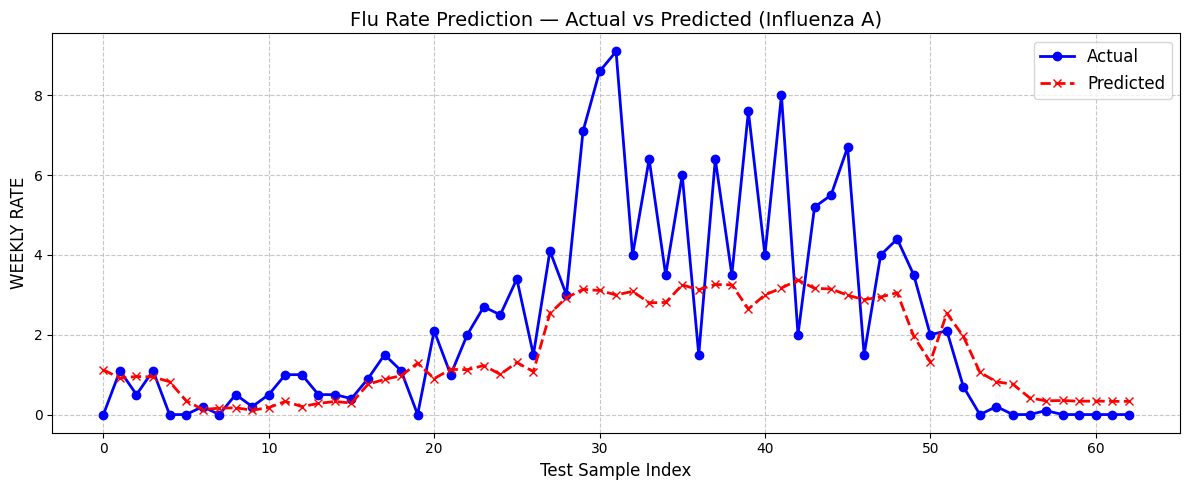

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot actual values
plt.plot(y_true.values, label="Actual", marker='o', color='blue', linewidth=2)

# Plot predicted values
plt.plot(y_pred, label="Predicted", marker='x', linestyle='--', color='red', linewidth=2)

# Title and axis labels
plt.title(f"Flu Rate Prediction — Actual vs Predicted ({virus_group})", fontsize=14)
plt.xlabel("Test Sample Index", fontsize=12)
plt.ylabel("WEEKLY RATE", fontsize=12)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#### Virus Type: Influenza B

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# === 1. Select subset ===
virus_group = "Influenza B"
df_virus = df_enhanced[
    (df_enhanced["AGE CATEGORY"] == "Overall") &
    (df_enhanced["VIRUS TYPE CATEGORY"] == virus_group) &
    (df_enhanced["is_flu_season"] == 1)
].copy().dropna().sort_values("date").reset_index(drop=True)

# === 2. Log transform target ===
df_virus["target_log"] = np.log1p(df_virus["WEEKLY RATE"])

# === 3. Define features ===
exclude = [
    "date", "time", "WEEKLY RATE", "YEAR", "WEEK",
    "month", "weekofyear", "AGE CATEGORY", "VIRUS TYPE CATEGORY", "target_log"
]
X = df_virus.drop(columns=exclude, errors="ignore").select_dtypes(include="number")
y_log = df_virus["target_log"]

# === 4. Temporal train/test split (70/30) ===
# Ensure there are enough rows for the split
if len(df_virus) < 10:  # Minimum threshold for train/test split
    print(f"Not enough data points ({len(df_virus)}) in the filtered dataset for train/test split.")
    print("Skipping training for AGE CATEGORY =", age_group)
else:
    # Proceed with train/test split and model training
    split_idx = max(1, int(len(df_virus) * 0.7))  # Ensure at least one sample in training set
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_log.iloc[:split_idx], y_log.iloc[split_idx:]

    # Train model
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_log = rf.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"Random Forest for AGE CATEGORY = {age_group}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.3f}")

# Ensure there are enough rows for the split
if len(df_virus) < 10:  # Minimum threshold for train/test split
    print(f"Not enough data points ({len(df_virus)}) in the filtered dataset for train/test split.")
    print("Skipping training for AGE CATEGORY =", age_group)
else:
    # Proceed with train/test split and model training
    split_idx = max(1, int(len(df_virus) * 0.7))  # Ensure at least one sample in training set
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_log.iloc[:split_idx], y_log.iloc[split_idx:]

    # Train model
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_log = rf.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"Random Forest for AGE CATEGORY = {age_group}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.3f}")

Random Forest for AGE CATEGORY = 0-4 yr
RMSE: 0.28
R²:   0.610
Random Forest for AGE CATEGORY = 0-4 yr
RMSE: 0.28
R²:   0.610


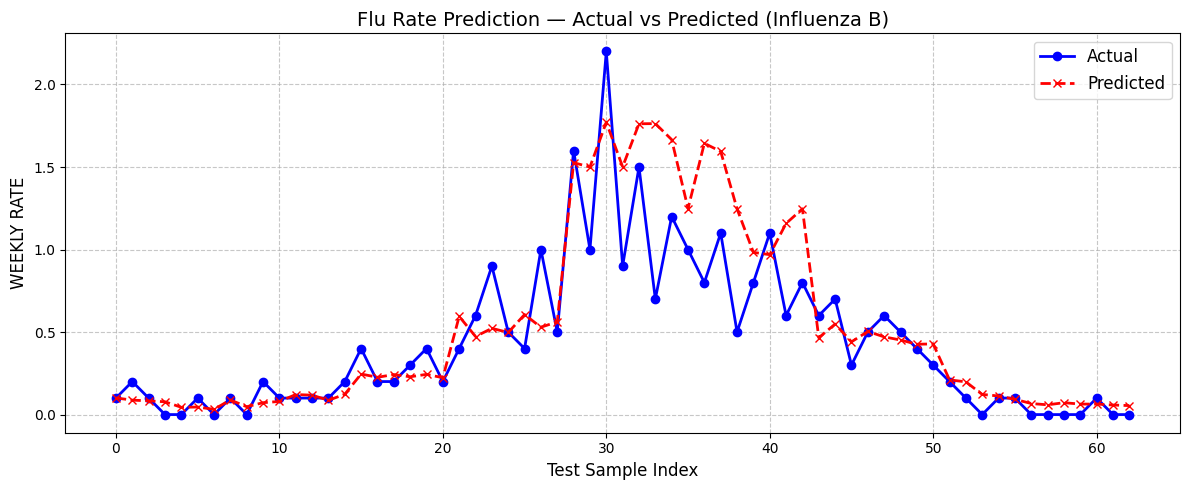

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot actual values
plt.plot(y_true.values, label="Actual", marker='o', color='blue', linewidth=2)

# Plot predicted values
plt.plot(y_pred, label="Predicted", marker='x', linestyle='--', color='red', linewidth=2)

# Title and axis labels
plt.title(f"Flu Rate Prediction — Actual vs Predicted ({virus_group})", fontsize=14)
plt.xlabel("Test Sample Index", fontsize=12)
plt.ylabel("WEEKLY RATE", fontsize=12)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Summary & Insights: Age&Virus-specific Flu Prediction Models

In this second modeling phase, we trained separate models for each age group and virus type using the same methodology as the global model: log-transformed target variable, weather and time-lag features, and a temporal train-test split with a Random Forest model.

Observations:
- Age-specific models, such as for individuals aged 65 and older, showed strong predictive performance (e.g., R² above 0.90), indicating that flu incidence patterns can vary by age and benefit from targeted modeling.
- The model for children aged 0–4 years also performed strong (R² above 0.75) but not as good as for 65+. This may be due to higher variability in the data or under-reporting in this age group, which limits the model’s ability to learn consistent seasonal and meteorological patterns.
- Virus-specific models, particularly for Influenza A, achieved reasonable accuracy. However, the prediction was less stable for Influenza B, possibly due to fewer cases or inconsistencies in detection and reporting.

**Conclusion**

Training models by age or virus type can lead to modest improvements in specific cases. However, this comes with increased model complexity and a higher risk of overfitting when data is limited. The global model, trained on the full dataset, remained more robust and accurate overall.

This suggests that, for this task, data quantity and consistency outweigh the potential benefits of granularity. Segment-specific models may still be useful for exploratory analysis or public health decisions, but they should be applied with caution when the data is limited.

While global models offer robust and generalizable predictions across the entire population, **age- or virus-specific models are useful when the goal is to support targeted healthcare interventions or to monitor the spread of specific strains**.

# Step 5: Comparison & Discussion

In [23]:
# Define all evaluation metrics
rmse_0_4 = 1.22
r2_0_4 = 0.768

rmse_65p = 1.65
r2_65p = 0.913

rmse_a = 1.88
r2_a = 0.443

rmse_b = 0.28
r2_b = 0.61

# Example: Build comparison table
results_summary = pd.DataFrame([
    {"Model": "Global model (Overall)", "RMSE": 0.45, "R²": 0.93},
    {"Model": "Age 0–4", "RMSE": rmse_0_4, "R²": r2_0_4},
    {"Model": "Age 65+", "RMSE": rmse_65p, "R²": r2_65p},
    {"Model": "Influenza A", "RMSE": rmse_a, "R²": r2_a},
    {"Model": "Influenza B", "RMSE": rmse_b, "R²": r2_b},
], columns=["Model", "RMSE", "R²"])

# Sort by RMSE or R²
results_summary = results_summary.sort_values("RMSE")
display(results_summary.round(3))

,Model,RMSE,R²
4,Influenza B,0.28,0.610
0,Global model (Overall),0.45,0.930
1,Age 0–4,1.22,0.768
2,Age 65+,1.65,0.913
3,Influenza A,1.88,0.443


**ERROR ANALYSIS**
- Prediction errors are higher for subgroups with smaller sample sizes or more irregular patterns (e.g., Influenza B, infants).
- The model sometimes misses sharp spikes in flu rates, especially when they are not aligned with typical weather or seasonal patterns.
- Forecasts are smoother than the actual data, which may be a limitation of tree-based models and the log transformation.

**LIMITATIONS**
- The dataset is aggregated at the national level, with no regional breakdown.
- No interaction modeling between age category and virus type (e.g., no model specifically trained on ‘0–4 + Influenza A’, because of missing data).
- We only used basic tree-based models, and didn’t tune hyperparameters.
- External factors like vaccination campaigns or pandemics are not captured in the current features.

# Conclusion

**Recap of Assumptions**
- Flu incidence is influenced by weather (temperature, humidity) and temporal cycles (lags, seasonality).
- Predictive modeling using these variables can help anticipate flu outbreaks at a population level.

**Final Results**
- The global model (Overall population + virus, with time-lag and weather features) performed best:
RMSE ≈ 0.45, R² ≈ 0.93.
- Segmenting by age or virus type resulted in slightly worse performance, likely due to reduced training data and increased noise.

**Next Steps**
- Explore more advanced models: XGBoost, LSTM, or temporal ensembling.
- Test cross-granularity models (e.g., by age + virus).
- Enrich the dataset with external features: vaccination rates, mobility data, or regional effects.
- Incorporate real-time forecasting via automated retraining pipelines.